# Rockland: Age and Adult Self Report
*based on code by Rob Chavez - May 2nd, 2019*

<img src="http://compsan.org/images/CSAN_Logo.svg" alt="drawing" width="100"/> 

In [5]:
%matplotlib inline
from nltools.data import Brain_Data
from nilearn import plotting, image, input_data, datasets
import numpy as np
import pandas as pd
import os
import nltools as nlt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from scipy.stats import pearsonr
from nltools.plotting import plot_brain


# Load data

Here we load the group 4D file which contains each subject's fractional anisotropy file registered to standard space. This space is then masked by areas which showed high SNR across subjects. Included in the behavioral data is a randomly generated training/testing label for splitting the data.

In [6]:
os.chdir("/Users/moriahstendel/Downloads/")
behav = pd.read_csv('rockland_519_with_big_five.csv')
behav = behav.fillna(0)
behav['ID'] = np.arange(1,520)

In [7]:
# Load FA data
fa_data = Brain_Data('mo.merge.nii.gz', mask = 'mo_mask_thresholded.nii.gz', X = behav)

# plot masked mean FA
#fa_data.mean().plot()

In [8]:
behav.head(5)

,Unnamed: 0,V1,ID,VISIT,SUB_STUDY.x,DEM_001,DEM_002,DEM_003,DEM_004,DEM_006,...,NEOFFI_63,NEOFFI_64,NEOFFI_65,NEOFFI_66,NEOFFI_67,NEOFFI_68,NEOFFI_69,NEOFFI_70,NEOFFI_72,NEOFFI_73
0,1,1,1,VA-REP,Neurofeedbac,30.0,1,0,5,1.0,...,34.0,26.0,19.0,1,30,70,55,61,43,28
1,2,2,2,VA,Discoverysci,56.0,2,0,5,1.0,...,0.0,0.0,0.0,2,56,25,25,25,25,25
2,3,3,3,VA,Discoverysci,55.0,1,0,5,1.0,...,31.0,30.0,39.0,1,55,40,60,56,50,61
3,4,4,4,VA,Discoverysci,53.0,2,0,5,1.0,...,36.0,39.0,40.0,2,53,51,65,61,59,61
4,5,5,5,VA,Discoverysci,57.0,1,0,5,1.0,...,40.0,24.0,42.0,1,57,39,32,70,39,66


# Fit age model
Here we will fit the ridge regression model on the training data using a leave-one-out cross-validation and a alpha =.1. 

In [22]:
# split data one train/test
train = fa_data[fa_data.X['category']=='train']
subject_id = train.X['ID']
train.Y = train.X['AGE_04']

test = fa_data[fa_data.X['category']=='test']
test.Y = test.X['AGE_04']

# fit model
stats_age= train.predict(algorithm='ridge',plot=False, 
                         cv_dict={'type': 'loso','subject_id':subject_id},
                         **{'alpha':.1})

# save weight map for use later
age_weightmap = stats_age['weight_map'].data



overall Root Mean Squared Error: 0.00
overall Correlation: 1.00
overall CV Root Mean Squared Error: 7.43
overall CV Correlation: 0.84


# Apply model to test sample
Here we will apply the model to the out-of-sample data, print a scatter plot and summary stats.

Holdout: R = 0.7844798999987513, p = 1.92861502942803e-35, R2 = 0.615408713502051, RMSE =  7.982612501151899
Plotting unthresholded image


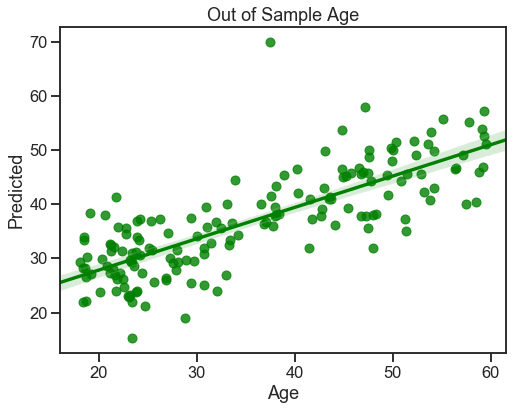

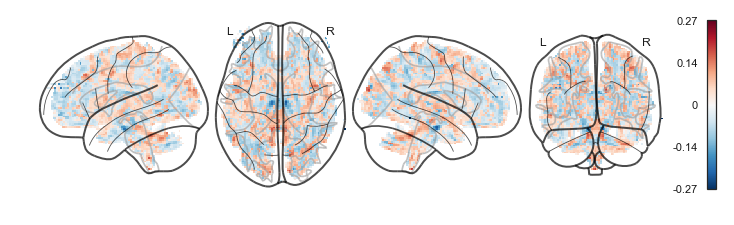

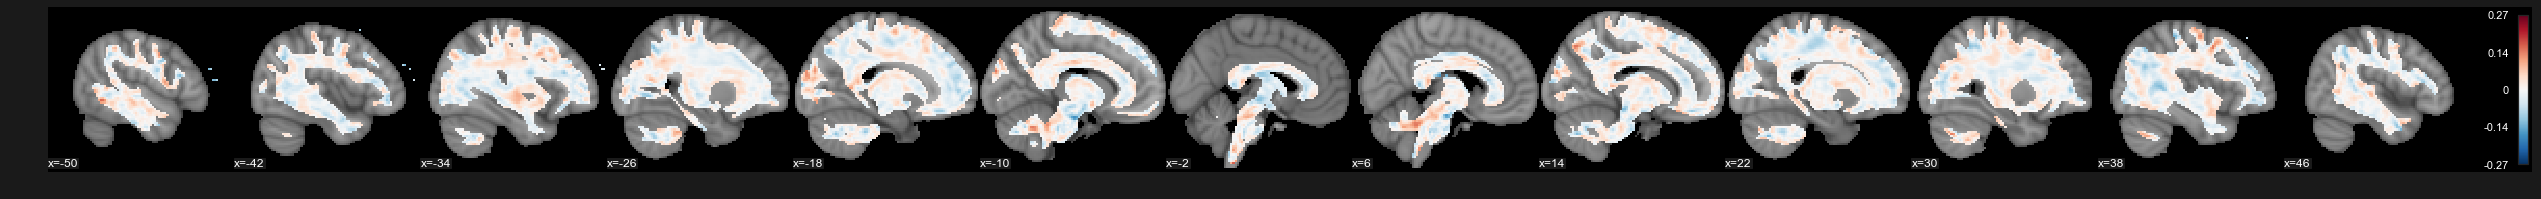

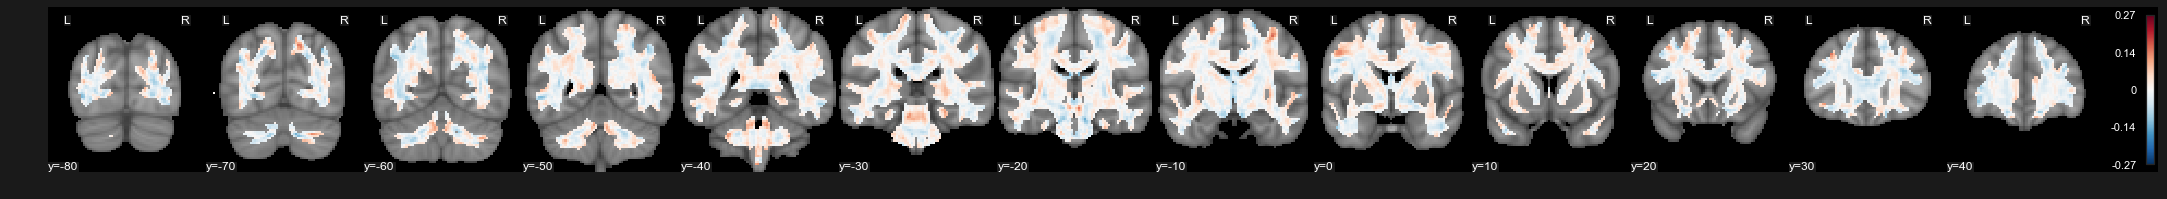

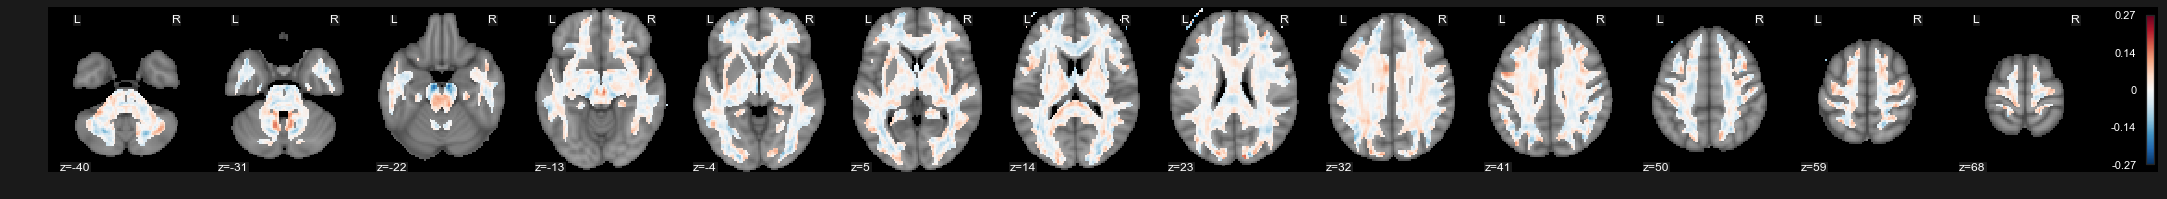

In [23]:
# apply predictions to holdout data
predicted_age = test.similarity(stats_age['weight_map'],'dot_product') + stats_age['intercept']

data_age = pd.DataFrame(data={'ID':test.X['ID'],'Predicted':predicted_age,'age':test.X['AGE_04']})

# scatter plot of predicted values
sns.set(rc={'figure.figsize':(8,6)})
sns.set_style("ticks")
with sns.plotting_context(context='talk',font_scale=1):
    sns.regplot(data=data_age,x='age',y='Predicted', color='green').set_title("Out of Sample Age")
    plt.xlabel('Age')

# calculate fit metrics    
fit = pearsonr(data_age.age, data_age.Predicted)
r2 = fit[0]**2
rmse = np.sqrt(mean_squared_error(data_age.age, data_age.Predicted))


print("Holdout: R = %s, p = %s, R2 = %s, RMSE =  %s" % (fit[0], fit[1], r2, rmse))

# plot brain
plot_brain(stats_age['weight_map'])

## Apply age model to Big Five variables
Here we will use the weight map from the neuroticism analysis to test its predictive utility on adult-self report T-score data.

### Neuroticism:

Holdout: R = -0.14397326843336697, p = 0.06587854414903645, R2 = 0.020728302023386342, RMSE =  17.92730847649905


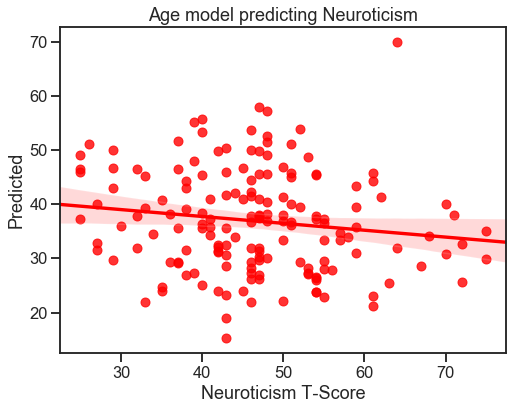

In [24]:
# apply predictions to holdout data
predicted_age = test.similarity(stats_age['weight_map'],'dot_product') + stats_age['intercept']

data_age = pd.DataFrame(data={'SubjectID':test.X['ID'],'Predicted':predicted_age,'neuroticism_tscore':test.X['NEOFFI_68']})

# scatter plot of predicted values
sns.set(rc={'figure.figsize':(8,6)})
sns.set_style("ticks")
with sns.plotting_context(context='talk',font_scale=1):
    sns.regplot(data=data_age,x='neuroticism_tscore',y='Predicted', color='red').set_title("Age model predicting Neuroticism")
    plt.xlabel('Neuroticism T-Score')

# calculate fit metrics    
fit = pearsonr(data_age.neuroticism_tscore, data_age.Predicted)
r2 = fit[0]**2
rmse = np.sqrt(mean_squared_error(data_age.neuroticism_tscore, data_age.Predicted))

print("Holdout: R = %s, p = %s, R2 = %s, RMSE =  %s" % (fit[0], fit[1], r2, rmse))

### Openness:

Holdout: R = -0.147159416039769, p = 0.06005411509331028, R2 = 0.021655893729165824, RMSE =  23.858175428150897


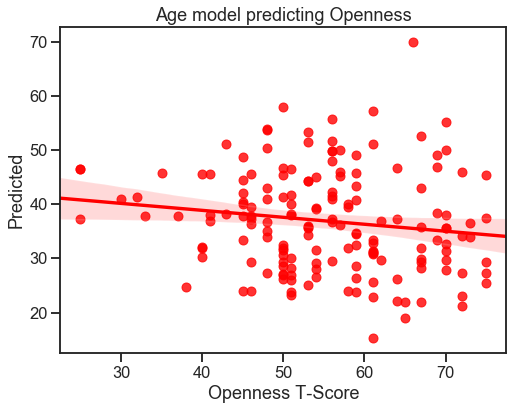

In [25]:
# apply predictions to holdout data
predicted_age = test.similarity(stats_age['weight_map'],'dot_product') + stats_age['intercept']

data_age = pd.DataFrame(data={'SubjectID':test.X['ID'],'Predicted':predicted_age,'open_tscore':test.X['NEOFFI_70']})

# scatter plot of predicted values
sns.set(rc={'figure.figsize':(8,6)})
sns.set_style("ticks")
with sns.plotting_context(context='talk',font_scale=1):
    sns.regplot(data=data_age,x='open_tscore',y='Predicted', color='red').set_title("Age model predicting Openness")
    plt.xlabel('Openness T-Score')

# calculate fit metrics    
fit = pearsonr(data_age.open_tscore, data_age.Predicted)
r2 = fit[0]**2
rmse = np.sqrt(mean_squared_error(data_age.open_tscore, data_age.Predicted))

print("Holdout: R = %s, p = %s, R2 = %s, RMSE =  %s" % (fit[0], fit[1], r2, rmse))

### Extraversion:

Holdout: R = -0.12000693536319045, p = 0.12586317564278438, R2 = 0.01440166453526497, RMSE =  21.3903762140759


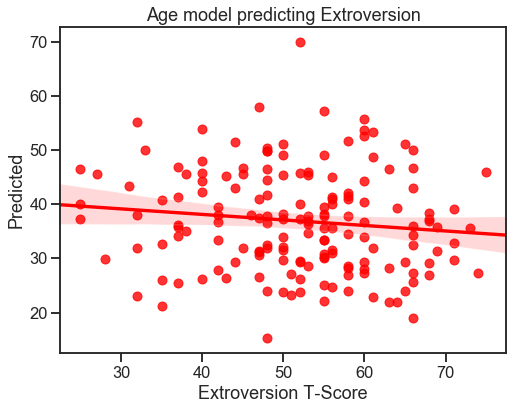

In [26]:
# apply predictions to holdout data
predicted_age = test.similarity(stats_age['weight_map'],'dot_product') + stats_age['intercept']

data_age = pd.DataFrame(data={'SubjectID':test.X['ID'],'Predicted':predicted_age,'extra_tscore':test.X['NEOFFI_69']})

# scatter plot of predicted values
sns.set(rc={'figure.figsize':(8,6)})
sns.set_style("ticks")
with sns.plotting_context(context='talk',font_scale=1):
    sns.regplot(data=data_age,x='extra_tscore',y='Predicted', color='red').set_title("Age model predicting Extroversion")
    plt.xlabel('Extroversion T-Score')

# calculate fit metrics    
fit = pearsonr(data_age.extra_tscore, data_age.Predicted)
r2 = fit[0]**2
rmse = np.sqrt(mean_squared_error(data_age.extra_tscore, data_age.Predicted))

print("Holdout: R = %s, p = %s, R2 = %s, RMSE =  %s" % (fit[0], fit[1], r2, rmse))

## Apply age model to psychopathology variables

### Internalizing:

Holdout: R = 0.01754196508964775, p = 0.8235778167409671, R2 = 0.00030772053920642044, RMSE =  51.52001209122121


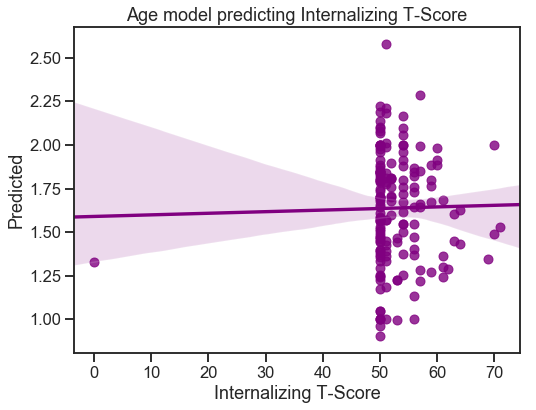

In [11]:
# apply predictions to holdout data
predicted_age = test.similarity(stats_age['weight_map'],'dot_product') + stats_age['intercept']

data_age = pd.DataFrame(data={'SubjectID':test.X['ID'],'Predicted':predicted_age,'internalizing_tscore':test.X['ASRM_147']})

# scatter plot of predicted values
sns.set(rc={'figure.figsize':(8,6)})
sns.set_style("ticks")
with sns.plotting_context(context='talk',font_scale=1):
    sns.regplot(data=data_age,x='internalizing_tscore',y='Predicted', color='purple').set_title("Age model predicting Internalizing T-Score")
    plt.xlabel('Internalizing T-Score')
        
# calculate fit metrics    
fit = pearsonr(data_age.internalizing_tscore, data_age.Predicted)
r2 = fit[0]**2
rmse = np.sqrt(mean_squared_error(data_age.internalizing_tscore, data_age.Predicted))

print("Holdout: R = %s, p = %s, R2 = %s, RMSE =  %s" % (fit[0], fit[1], r2, rmse))


### Externalizing 

Holdout: R = 0.029961284580372744, p = 0.7033202008959796, R2 = 0.0008976785737060815, RMSE =  47.32853541962183


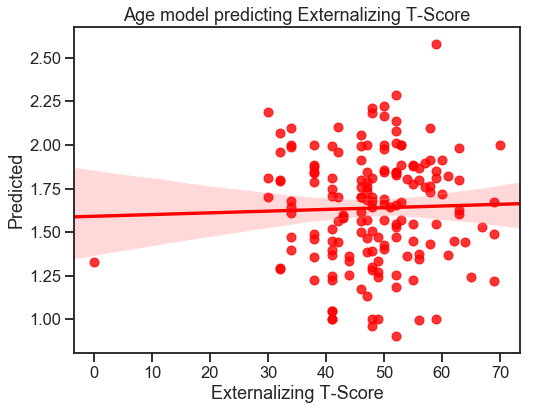

In [12]:
# apply predictions to holdout data
predicted_age = test.similarity(stats_age['weight_map'],'dot_product') + stats_age['intercept']

data_age = pd.DataFrame(data={'SubjectID':test.X['ID'],'Predicted':predicted_age,'externalizing_tscore':test.X['ASRM_158']})

# scatter plot of predicted values
sns.set(rc={'figure.figsize':(8,6)})
sns.set_style("ticks")
with sns.plotting_context(context='talk',font_scale=1):
    sns.regplot(data=data_age,x='externalizing_tscore',y='Predicted', color='red').set_title("Age model predicting Externalizing T-Score")
    plt.xlabel('Externalizing T-Score')

# calculate fit metrics    
fit = pearsonr(data_age.externalizing_tscore, data_age.Predicted)
r2 = fit[0]**2
rmse = np.sqrt(mean_squared_error(data_age.externalizing_tscore, data_age.Predicted))

print("Holdout: R = %s, p = %s, R2 = %s, RMSE =  %s" % (fit[0], fit[1], r2, rmse))


### Anxious/Depressed:

Holdout: R = -0.04006471339745409, p = 0.610500734999881, R2 = 0.0016051812596201375, RMSE =  52.14155453985426


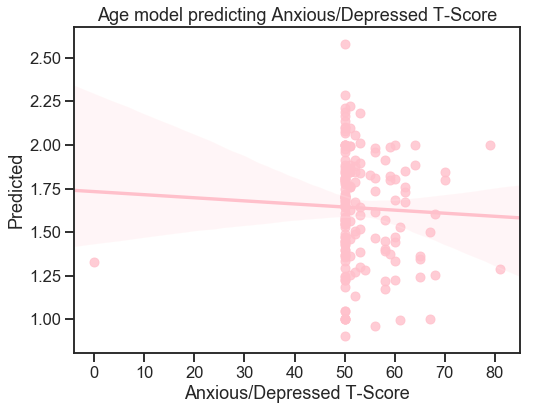

In [13]:
# apply predictions to holdout data
predicted_age = test.similarity(stats_age['weight_map'],'dot_product') + stats_age['intercept']

data_age = pd.DataFrame(data={'SubjectID':test.X['ID'],'Predicted':predicted_age,'anxious_depressed_tscore':test.X['ASRM_148']})

# scatter plot of predicted values
sns.set(rc={'figure.figsize':(8,6)})
sns.set_style("ticks")
with sns.plotting_context(context='talk',font_scale=1):
    sns.regplot(data=data_age,x='anxious_depressed_tscore',y='Predicted', color='pink').set_title("Age model predicting Anxious/Depressed T-Score")
    plt.xlabel('Anxious/Depressed T-Score')

# calculate fit metrics    
fit = pearsonr(data_age.anxious_depressed_tscore, data_age.Predicted)
r2 = fit[0]**2
rmse = np.sqrt(mean_squared_error(data_age.anxious_depressed_tscore, data_age.Predicted))

print("Holdout: R = %s, p = %s, R2 = %s, RMSE =  %s" % (fit[0], fit[1], r2, rmse))

### Withdrawn:

Holdout: R = -0.02279452135285319, p = 0.772032618649801, R2 = 0.00051959020370568, RMSE =  52.84093199002958


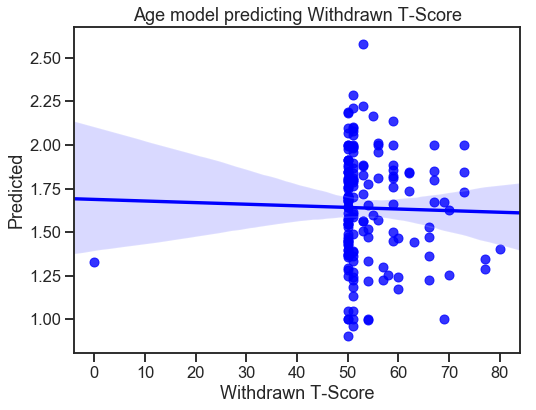

In [14]:
# apply predictions to holdout data
predicted_age = test.similarity(stats_age['weight_map'],'dot_product') + stats_age['intercept']

data_age = pd.DataFrame(data={'SubjectID':test.X['ID'],'Predicted':predicted_age,'withdrawn_tscore':test.X['ASRM_149']})

# scatter plot of predicted values
sns.set(rc={'figure.figsize':(8,6)})
sns.set_style("ticks")
with sns.plotting_context(context='talk',font_scale=1):
    sns.regplot(data=data_age,x='withdrawn_tscore',y='Predicted', color='blue').set_title("Age model predicting Withdrawn T-Score")
    plt.xlabel('Withdrawn T-Score')

# calculate fit metrics    
fit = pearsonr(data_age.withdrawn_tscore, data_age.Predicted)
r2 = fit[0]**2
rmse = np.sqrt(mean_squared_error(data_age.withdrawn_tscore, data_age.Predicted))

print("Holdout: R = %s, p = %s, R2 = %s, RMSE =  %s" % (fit[0], fit[1], r2, rmse))

### Somatic:

Holdout: R = -0.0037150759056522784, p = 0.9623439086495666, R2 = 1.3801788984758097e-05, RMSE =  52.35394336006592


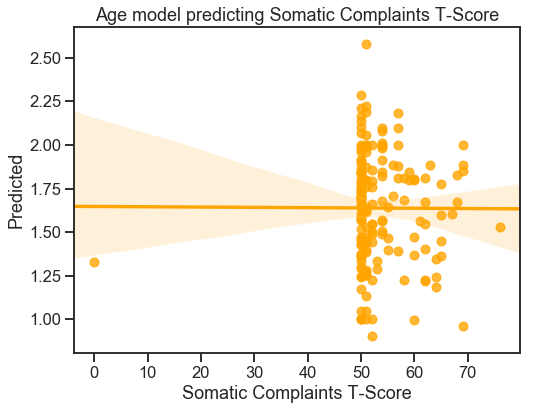

In [15]:
# apply predictions to holdout data
predicted_age = test.similarity(stats_age['weight_map'],'dot_product') + stats_age['intercept']

data_age = pd.DataFrame(data={'SubjectID':test.X['ID'],'Predicted':predicted_age,'somatic_tscore':test.X['ASRM_150']})

# scatter plot of predicted values
sns.set(rc={'figure.figsize':(8,6)})
sns.set_style("ticks")
with sns.plotting_context(context='talk',font_scale=1):
    sns.regplot(data=data_age,x='somatic_tscore',y='Predicted', color='orange').set_title("Age model predicting Somatic Complaints T-Score")
    plt.xlabel('Somatic Complaints T-Score')

# calculate fit metrics    
fit = pearsonr(data_age.somatic_tscore, data_age.Predicted)
r2 = fit[0]**2
rmse = np.sqrt(mean_squared_error(data_age.somatic_tscore, data_age.Predicted))

print("Holdout: R = %s, p = %s, R2 = %s, RMSE =  %s" % (fit[0], fit[1], r2, rmse))

### Thought Problems:

Holdout: R = 0.044172279675208745, p = 0.574369062531175, R2 = 0.0019511902917048595, RMSE =  50.69743672668725


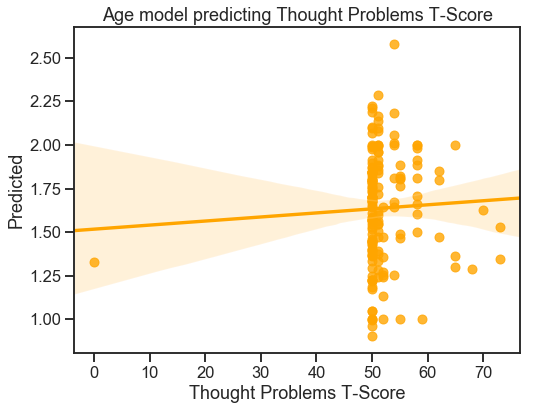

In [16]:
# apply predictions to holdout data
predicted_age = test.similarity(stats_age['weight_map'],'dot_product') + stats_age['intercept']

data_age = pd.DataFrame(data={'SubjectID':test.X['ID'],'Predicted':predicted_age,'thought_tscore':test.X['ASRM_151']})

# scatter plot of predicted values
sns.set(rc={'figure.figsize':(8,6)})
sns.set_style("ticks")
with sns.plotting_context(context='talk',font_scale=1):
    sns.regplot(data=data_age,x='thought_tscore',y='Predicted', color='orange').set_title("Age model predicting Thought Problems T-Score")
    plt.xlabel('Thought Problems T-Score')

# calculate fit metrics    
fit = pearsonr(data_age.thought_tscore, data_age.Predicted)
r2 = fit[0]**2
rmse = np.sqrt(mean_squared_error(data_age.thought_tscore, data_age.Predicted))

print("Holdout: R = %s, p = %s, R2 = %s, RMSE =  %s" % (fit[0], fit[1], r2, rmse))

### Attention Problems:

Holdout: R = -0.029052575442383863, p = 0.7119140402682589, R2 = 0.0008440521398354059, RMSE =  53.29694287375435


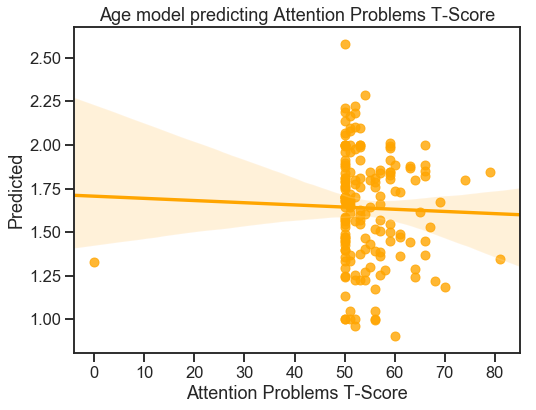

In [17]:
# apply predictions to holdout data
predicted_age = test.similarity(stats_age['weight_map'],'dot_product') + stats_age['intercept']

data_age = pd.DataFrame(data={'SubjectID':test.X['ID'],'Predicted':predicted_age,'attn_tscore':test.X['ASRM_152']})

# scatter plot of predicted values
sns.set(rc={'figure.figsize':(8,6)})
sns.set_style("ticks")
with sns.plotting_context(context='talk',font_scale=1):
    sns.regplot(data=data_age,x='attn_tscore',y='Predicted', color='orange').set_title("Age model predicting Attention Problems T-Score")
    plt.xlabel('Attention Problems T-Score')

# calculate fit metrics    
fit = pearsonr(data_age.attn_tscore, data_age.Predicted)
r2 = fit[0]**2
rmse = np.sqrt(mean_squared_error(data_age.attn_tscore, data_age.Predicted))

print("Holdout: R = %s, p = %s, R2 = %s, RMSE =  %s" % (fit[0], fit[1], r2, rmse)) 

### Aggressive Behaviour:

Holdout: R = 0.07683170285482863, p = 0.3281503457812429, R2 = 0.005903110563572681, RMSE =  51.230664079327994


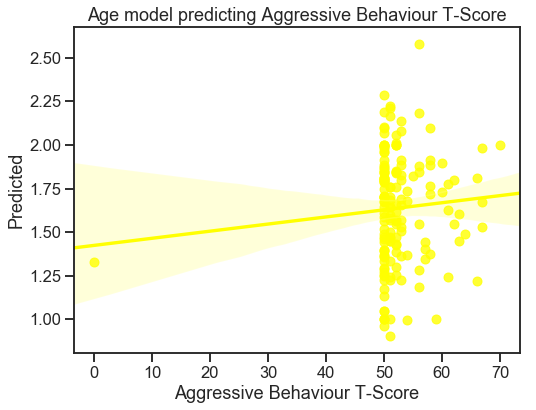

In [18]:
# apply predictions to holdout data
predicted_age = test.similarity(stats_age['weight_map'],'dot_product') + stats_age['intercept']

data_age = pd.DataFrame(data={'SubjectID':test.X['ID'],'Predicted':predicted_age,'agg_tscore':test.X['ASRM_153']})

# scatter plot of predicted values
sns.set(rc={'figure.figsize':(8,6)})
sns.set_style("ticks")
with sns.plotting_context(context='talk',font_scale=1):
    sns.regplot(data=data_age,x='agg_tscore',y='Predicted', color='yellow').set_title("Age model predicting Aggressive Behaviour T-Score")
    plt.xlabel('Aggressive Behaviour T-Score')

# calculate fit metrics    
fit = pearsonr(data_age.agg_tscore, data_age.Predicted)
r2 = fit[0]**2
rmse = np.sqrt(mean_squared_error(data_age.agg_tscore, data_age.Predicted))

print("Holdout: R = %s, p = %s, R2 = %s, RMSE =  %s" % (fit[0], fit[1], r2, rmse)) 

### Rule Breaking:

Holdout: R = 0.06995249465767436, p = 0.3734294032083162, R2 = 0.004893351508831961, RMSE =  53.024830057559335


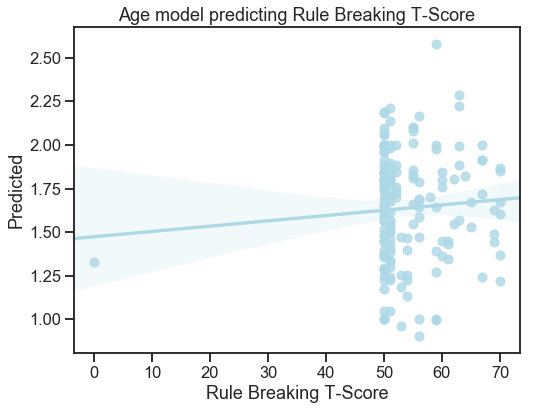

In [19]:
# apply predictions to holdout data
predicted_age= test.similarity(stats_age['weight_map'],'dot_product') + stats_age['intercept']

data_age = pd.DataFrame(data={'SubjectID':test.X['ID'],'Predicted':predicted_age,'rule_tscore':test.X['ASRM_154']})

# scatter plot of predicted values
sns.set(rc={'figure.figsize':(8,6)})
sns.set_style("ticks")
with sns.plotting_context(context='talk',font_scale=1):
    sns.regplot(data=data_age,x='rule_tscore',y='Predicted', color='lightblue').set_title("Age model predicting Rule Breaking T-Score")
    plt.xlabel('Rule Breaking T-Score')

# calculate fit metrics    
fit = pearsonr(data_age.rule_tscore, data_age.Predicted)
r2 = fit[0]**2
rmse = np.sqrt(mean_squared_error(data_age.rule_tscore, data_age.Predicted))

print("Holdout: R = %s, p = %s, R2 = %s, RMSE =  %s" % (fit[0], fit[1], r2, rmse)) 

### Instrusive

Holdout: R = 0.08625109917572456, p = 0.2721379837576592, R2 = 0.007439252109020673, RMSE =  50.935162032143246


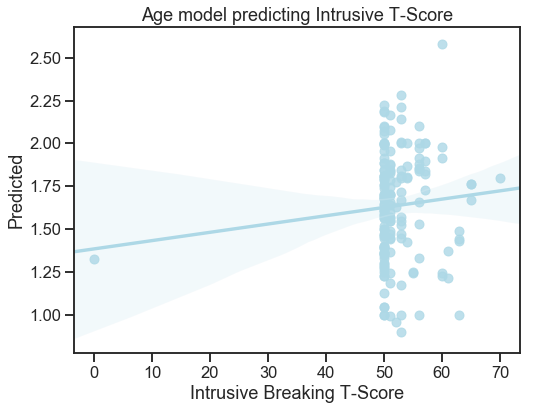

In [20]:
# apply predictions to holdout data
predicted_age = test.similarity(stats_age['weight_map'],'dot_product') + stats_age['intercept']

data_age = pd.DataFrame(data={'SubjectID':test.X['ID'],'Predicted':predicted_age,'intrusive_tscore':test.X['ASRM_155']})

# scatter plot of predicted values
sns.set(rc={'figure.figsize':(8,6)})
sns.set_style("ticks")
with sns.plotting_context(context='talk',font_scale=1):
    sns.regplot(data=data_age,x='intrusive_tscore',y='Predicted', color='lightblue').set_title("Age model predicting Intrusive T-Score")
    plt.xlabel('Intrusive Breaking T-Score')

# calculate fit metrics    
fit = pearsonr(data_age.intrusive_tscore, data_age.Predicted)
r2 = fit[0]**2
rmse = np.sqrt(mean_squared_error(data_age.intrusive_tscore, data_age.Predicted))

print("Holdout: R = %s, p = %s, R2 = %s, RMSE =  %s" % (fit[0], fit[1], r2, rmse)) 